In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arnaldoch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Step 1. Read and save the dataset
# Dataset: BBC News
# Authors: D. Greene and P. Cunningham.
# Description: Consists of 2225 documents from the BBC news website 
# corresponding to stories in five topical areas from 2004-2005.
# Class Labels: 5 (business, entertainment, politics, sport, tech)
# Source: http://mlg.ucd.ie/datasets/bbc.html
# Related documents: "Practical Solutions to the Problem of Diagonal 
# Dominance in Kernel Document Clustering", Proc. ICML 2006.
# Document url: http://mlg.ucd.ie/files/publications/greene06icml.pdf
# data = load_files('./bbc/',encoding='utf-8',decode_error='replace')
# labels, counts = np.unique(data.target, return_counts=True)
# labels_str = np.array(data.target_names)[labels]
# df_raw = pd.DataFrame(data.data, columns=['text'])
# df_raw['target'] = pd.Series(data.target)
# df_raw['target'] = df_raw['target'].map({0:'business', 1:'entertainment', 
# 2:'politics',3:'sport',4:'tech'})


In [5]:
df_raw = pd.read_pickle('../raw_dataset.pkl')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   target  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
df_raw.sample(10, random_state=2018)

,text,target
1678,Venus stunned by Farina Elia\n\nVenus Williams...,sport
1034,Rock band U2 break ticket record\n\nU2 have sm...,entertainment
1853,British stars denied major Oscars\n\nBritish h...,entertainment
1078,Could Yukos be a blessing in disguise?\n\nOthe...,business
466,Kluft impressed by Sotherton form\n\nOlympic h...,sport
2011,Malaysia lifts Islamic bank limit\n\nMalaysia'...,business
860,Animation charms Japan box office\n\nOscar-win...,entertainment
1947,Collins appeals against drugs ban\n\nSprinter ...,sport
1310,Burglar defence guidelines issued\n\nHousehold...,politics
976,"Parmalat boasts doubled profits\n\nParmalat, t...",business


In [7]:
df = df_raw[(df_raw.target=='sport') | (df_raw.target=='business')].reset_index(drop=True).copy()

df.target.value_counts()

target
sport       511
business    510
Name: count, dtype: int64

In [8]:
#PREPROCESADOR
#Este preprocesador debemos hacerlo en un archivo .py

stop_words = stopwords.words('english')

#Se eliminan las palabras innecesarias/reduntates: and, or, ...
def remove_stopwords(text:str)->str:
    clean_text = []
    if text is not None:
        words = text.split()
        for word in words:
            if word not in stop_words:
                clean_text.append(str(word))
        return ' '.join(clean_text)
    else:
        return None

def remove_symbols(text:str)->str:
    if text is not None:
        text = text.lower()
        text = re.sub(r'''[.,?*&'"+${}-]''','',text)
        text = re.sub(r"\n",' ',text)
        return text
    else:
        return None

In [9]:
df['text_clean'] = df['text'].apply(lambda x: remove_symbols(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))

In [10]:
#Explode lo convierte en el momento y luego lo convierta a columna. En columna temporal 'text' 
df_word_split = (df[['text_clean']]
                .assign(text = df['text_clean'].str.split())).explode('text').drop('text_clean', axis=1)
                
df_word_split['text'].value_counts()

text
said         2417
us           1001
would         859
year          832
also          768
             ... 
a380s           1
airliners       1
doctoring       1
falsify         1
oneonone        1
Name: count, Length: 21267, dtype: int64

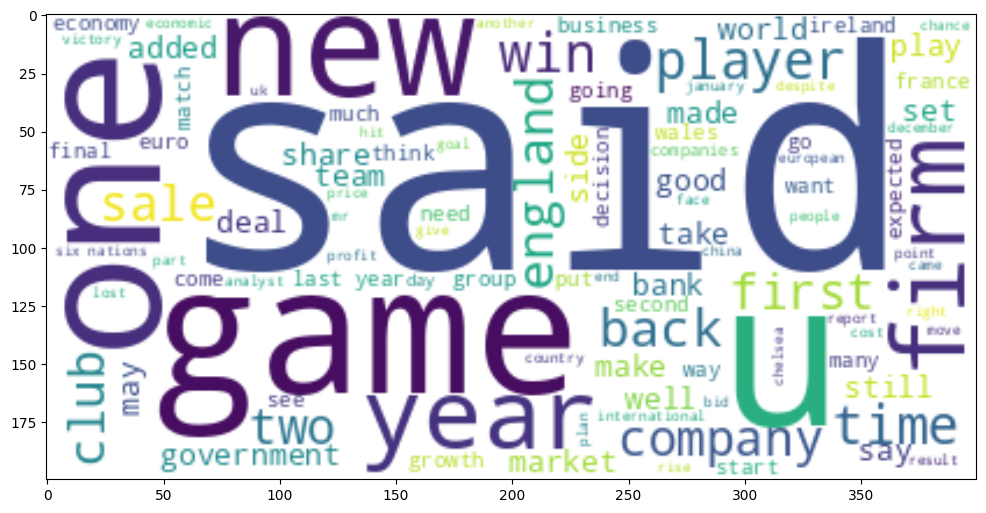

In [12]:
text = ' '.join(i for i in df['text_clean'])

word_cloud = WordCloud(max_words=100, background_color='White').generate(text)

plt.figure(figsize=(12,12))

plt.imshow(word_cloud, interpolation='bilinear')

plt.show()

In [15]:
#Este EDA se tuvo que hacer sobre el set de datos de Train. Previo a aplicar el train_test_split

X = df['text_clean'].reset_index(drop=True).copy()
y = df['target'].reset_index(drop=True).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2100) #stratify=y mitad y mitad, en parejo

In [16]:
#Se procede a hacer la tokenizacion. El texto lo convierte en matriz. Cada palabra es una columna
#Como hay palabras muy repetidas, debe aplicarse una formula para reducirle la dominancia.
#Con el algoritmo tfidf aplica una formula para que las palabras sobrerepresentadas no cargen en la matriz 

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=1.0)#min_df: Flotante de 0 a 1, Entero: La cuenta. cuantas veces tiene que haber aparecido la palabra para considerarla o eliminar

X_vectorized = vectorizer.fit_transform(X_train)

vectorizer.get_feature_names_out() #Para ver cuáles palabras quedaron

array(['01', '02', '03', ..., 'zero', 'zone', 'zurich'], dtype=object)

In [17]:
X_vectorized #Matrices con multiples 0 adentro, se le llama matriz sparse.

<765x4225 sparse matrix of type '<class 'numpy.float64'>'
	with 87149 stored elements in Compressed Sparse Row format>

In [18]:
vectorizer.get_feature_names_out().shape #Cuantas palabras quedaron

(4225,)

In [20]:
#El texto es cantidato a reduccion. Se usa el algoritmo de PCA
#PCA toma el eje con mayor varianza y sobre esa comienza a crear vectores ortogonales, asi con los de mayor varianza, luego se usa ley de pareto
#para elegir los primeros vectores.
#Se hace una reduccion porque le dimos. Se rotan los datos y se busca la mayor varianza.

pca = PCA(n_components=2, random_state=2109)
pca_vecs = pca.fit_transform(X_vectorized.toarray()) #to_array() Los algoritmos siempre exigen que sea una matriz

In [21]:
pca_vecs #Se transformo el texto a vectores

array([[-0.1392543 ,  0.02231243],
       [-0.07997904,  0.02292446],
       [ 0.11430863, -0.04336316],
       ...,
       [-0.11182445, -0.10899764],
       [-0.21058292,  0.26435761],
       [ 0.16986478, -0.00440323]])

In [22]:
labels = y_train.reset_index(drop=True)

In [25]:
pca_df = pd.DataFrame()

pca_df['x_0'] = pca_vecs[:,0] #Todas las filas :,   | Columna 0
pca_df['x_1'] = pca_vecs[:,1] #Todas las filas :,   | Columna 1
pca_df['labels'] = labels

/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/dim_reduction/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/dim_reduction/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/dim_reduction/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/C

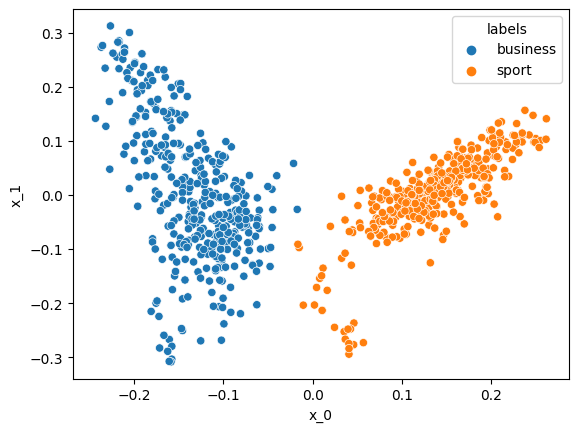

In [26]:
sns.scatterplot(data=pca_df, x='x_0', y='x_1', hue='labels')
plt.show()